# Clustering

In this assignment, you will implement a K-Means Clustering algorithm from scratch and compare the results to existing sklearn algorithm.

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as date
import random
from sklearn.preprocessing import StandardScaler

Question 1.1: Write a method that determine Labels from Points and ClusterCentroids, and return a list of a label for each point

In [29]:
# Calculate the euclidean distance from the centroid (point) and all of the data points (data)
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2))

# Find label of closest cluster for all points
def FindLabelOfClosest(Points, ClusterCentroids): # determine Labels from Points and ClusterCentroids
    NumberOfClusters, NumberOfDimensions = ClusterCentroids.shape # dimensions of the initial Centroids
    NumberOfPoints, NumberOfDimensions = Points.shape
    Distances = np.full((NumberOfClusters, 1), np.nan) # distance to each of 4 centroids
    Labels = np.full((NumberOfPoints, 1), np.nan)
    for PointNumber in range(NumberOfPoints): # assign labels to all data points
        for ClusterNumber in range(NumberOfClusters): # for each cluster
            # Get distances for each cluster
            Distances[ClusterNumber] = euclidean(Points.loc[PointNumber, :], ClusterCentroids.loc[ClusterNumber, :])
        Labels[PointNumber] = Distances.argmin()
    return Labels # return the a label for each point

Question 1.2: Write a method that determine centroid of Points with the same label

In [30]:
def CalculateClusterCentroid(Points, Labels): # determine centroid of Points with the same label
    ClusterLabels = np.unique(Labels) # names of labels
    NumberOfPoints, NumberOfDimensions = Points.shape
    # Make a dataframe that contains all of the data points along with their labels
    tmp_labels_df = pd.DataFrame(Labels, columns=['labels'])
    tmp_combined_df = pd.concat([Points, tmp_labels_df], axis=1)
    # Calculate the mean of each column for each cluster label
    ClusterCentroids = tmp_combined_df.groupby(by=['labels']).mean()
    return ClusterCentroids # return the centroid for each label

Question 1.3: Put it all together as such. K-means algorithm partitions the input data into K clusters by iterating between the following two steps:
- Compute the cluster center by computing the arithmetic mean of all the points belonging to the cluster.
- Assign each point to the closest cluster center.

In [31]:
def KMeans(Points, ClusterCentroidGuesses):
    ClusterCentroids = ClusterCentroidGuesses.copy()
    ClusterCentroids.reset_index(inplace=True, drop=True)
    Labels_Previous = None
    # Get starting set of labels
    Labels = FindLabelOfClosest(Points, ClusterCentroids)
    # Continue recalculating cluster centroids, assigning labels to clusters, and repeating
    # Until the labels do not change between two subsequent iterations
    while not np.array_equal(Labels, Labels_Previous):
        print('iterating')
        # Re-calculate cluster centers based on new set of labels
        ClusterCentroids = CalculateClusterCentroid(Points,Labels)
        Labels_Previous = Labels.copy() # Must make a deep copy
    #     # Determine new labels based on new cluster centers
        Labels = FindLabelOfClosest(Points, ClusterCentroids)
    return Labels, ClusterCentroids

In [32]:
# Read in data set
StoreTxn = pd.read_csv("Week 6/Superstore Transaction data.csv")
StoreTxn['Order Date'] = pd.to_datetime(StoreTxn['Order Date'] )
StoreTxn.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Extract RFM features from the transaction data:
- Recency: when was the last purchase they made
- Frequency: how often do they make a purchase in the last month (or any given window you choose)
- Monetary: how much money did they spend in the last month

Question 2.1:
- Use groupby to summarize the quantity and dollar columns by user_id and date
- Name the aggregated data txn_agg
- Reset the index for txn_agg to the default and user_id and date to dataframe columns
- Confirm changes

In [33]:
#Summarize quantity and dollar by user_id - date.
txn_agg = StoreTxn.groupby(['Customer ID', 'Order Date'])[['Quantity', 'Sales']].sum().reset_index()
txn_agg.head(10)

,Customer ID,Order Date,Quantity,Sales
0,AA-10315,2014-03-31,4,726.548
1,AA-10315,2014-09-15,5,29.500
2,AA-10315,2015-10-04,2,26.960
3,AA-10315,2016-03-03,14,4406.072
4,AA-10315,2017-06-29,5,374.480
5,AA-10375,2014-04-21,5,16.520
6,AA-10375,2014-10-24,3,34.272
7,AA-10375,2015-02-03,5,178.370
8,AA-10375,2015-05-08,2,5.248
9,AA-10375,2015-11-13,6,84.960


Question 2.2:Using the aggregated data, obtain recency, frequency and monetary features for both dollar and quantity. Use a 7-day moving window for frequency and monetary. Call your new features last_visit_ndays (recency) quantity_roll_sum_7D (frequency) and dollar_roll_sum_7D (monetary)

**Note I am assuming that the recency is the number of days between the current date (today) and the last purchase of each individual.** 

In [34]:
# Group the data by user_id and calculate lag as the difference between the current and previous date (lag by one period)
# Convert Order Date to datetime format
txn_agg['Order Date'] = pd.to_datetime(txn_agg['Order Date'])
# Extract Date only
txn_agg['Order Date Only'] = txn_agg['Order Date'].dt.strftime('%Y-%m-%d')
# Put Order Date Only in datetime format
txn_agg['Order Date Only'] = pd.to_datetime(txn_agg['Order Date Only'])
# Get the last purchase date for each customer
last_purchase_date = txn_agg.groupby(['Customer ID'])['Order Date Only'].max()
# Get today's date in datetime format
today = pd.to_datetime(date.date.today().strftime('%Y-%m-%d'))
# Calculate number of days between today's date and last purchase date
last =(today - last_purchase_date).dt.days
last = last.to_frame().reset_index()
last.rename(columns = {'Order Date Only' : 'last_visit_ndays'}, inplace = True) # Name the lagged date values last_visit_ndays
print(last.head(10), end='\n\n')

print(txn_agg.head(10), end='\n\n')

  Customer ID  last_visit_ndays
0    AA-10315              2540
1    AA-10375              2375
2    AA-10480              2615
3    AA-10645              2411
4    AB-10015              2771
5    AB-10060              2410
6    AB-10105              2397
7    AB-10150              2397
8    AB-10165              2381
9    AB-10255              2522

  Customer ID Order Date  Quantity     Sales Order Date Only
0    AA-10315 2014-03-31         4   726.548      2014-03-31
1    AA-10315 2014-09-15         5    29.500      2014-09-15
2    AA-10315 2015-10-04         2    26.960      2015-10-04
3    AA-10315 2016-03-03        14  4406.072      2016-03-03
4    AA-10315 2017-06-29         5   374.480      2017-06-29
5    AA-10375 2014-04-21         5    16.520      2014-04-21
6    AA-10375 2014-10-24         3    34.272      2014-10-24
7    AA-10375 2015-02-03         5   178.370      2015-02-03
8    AA-10375 2015-05-08         2     5.248      2015-05-08
9    AA-10375 2015-11-13         6   

**Note: Given that last has only one entry per user, I assumed that we were being asked for quantity and sales for each user, with no duplicate dates per user, even if they made purchases more than 7 days apart. Applying a 7 day moving window resulted in multiple dates for each user. To get one value for each user, I took the average value of all 7 day windows for each subject.** 

In [35]:
# Group the data by user_id.  Apply a 7 day offset to implement a moving 7-day window totaling quantity and dollars
# sold within each time window.

df = pd.DataFrame()
df['Customer ID'] = StoreTxn['Customer ID']
df['Quantity'] = StoreTxn['Quantity']
df['Sales'] = StoreTxn['Sales']

# Convert order date to type datetime
df['Order Date'] = pd.to_datetime(StoreTxn['Order Date'])
df['Order Date'] = df['Order Date'].dt.strftime('%Y-%m-%d')

#Sort by Customer ID and Order Date
df = df.sort_values(by = ['Customer ID', 'Order Date'])

def rolling_window(group):
    group['Order Date'] = pd.to_datetime(group['Order Date'])

    group = group.set_index('Order Date')
    # Name the resulting data values quantity_roll_sum_7D and Sales_roll_sum_7D

    group['Quantity_roll_sum_7D'] = group['Quantity'].rolling(window=7, min_periods=1).sum()
    group['Sales_roll_sum_7D'] = group['Sales'].rolling(window=7, min_periods=1).sum()

    # Identify the last entry within each 7-day window for each customer
    last_dates = group.groupby('Customer ID').resample('7D').last().index.get_level_values(1)
    
    # The rolling window keeps all entries for all dates. Keep only the rows corresponding to the last date
    group = group[group.index.isin(last_dates)]

    return group.reset_index()

# Apply rolling window function to each customer group
roll = df.groupby('Customer ID').apply(rolling_window)


############ Average rolling values across all 7 day spans available for every customer ##########

# Reset index to get a flat dataframe
roll.reset_index(drop=True, inplace=True)

# Drop Quantity and Sales columns
roll.drop(columns=['Quantity', 'Sales'], inplace=True)

roll['Order Date'] = pd.to_datetime(roll['Order Date'])

groups = roll.groupby('Customer ID')

# function to remove duplicate transaction within each 7 day window
def remove_duplicates(group):
    #Apply rolling window of 7 days
    group = group.set_index('Order Date').resample('7D').last().reset_index()

    group = group.dropna()
    #Keep only last entry within each 7 day window
    group = group.drop_duplicates(subset=['Order Date'], keep='last')
    return group

result = groups.apply(remove_duplicates)
result.reset_index(drop=True, inplace=True)

# Remove H/M/S from Order Date column
result['Order Date'] = result['Order Date'].dt.strftime('%Y-%m-%d')

#average sales and quantity across all 7 days periods for each customer ID so there is one value for each customer
sales_quant_roll = result.groupby(['Customer ID'])[['Quantity_roll_sum_7D','Sales_roll_sum_7D']].mean().reset_index()

# Check resulting dataframe
print(sales_quant_roll.head(10), end='\n\n')

C:\Users\louis\AppData\Local\Temp\ipykernel_12980\3460654715.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  roll = df.groupby('Customer ID').apply(rolling_window)


  Customer ID  Quantity_roll_sum_7D  Sales_roll_sum_7D
0    AA-10315              6.500000         741.298000
1    AA-10375             13.000000         335.752667
2    AA-10480             10.000000         322.220000
3    AA-10645             21.666667        1453.780000
4    AB-10015              2.000000          12.624000
5    AB-10060              2.000000          18.540000
6    AB-10105             23.333333        4616.358333
7    AB-10150             16.000000         705.562000
8    AB-10165              7.000000         160.460000
9    AB-10255             12.500000          87.929000



C:\Users\louis\AppData\Local\Temp\ipykernel_12980\3460654715.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = groups.apply(remove_duplicates)


Question 2.3: Combine all three features into a single DataFrame and call it txn_roll

In [36]:
# Inner join between roll (sale and quantity fields) and last (recency fields) to create txn_roll.
txn_roll = pd.merge(last, sales_quant_roll, how='inner')

print(txn_roll.dtypes, end='\n\n')
txn_roll.head(10)

Customer ID              object
last_visit_ndays          int64
Quantity_roll_sum_7D    float64
Sales_roll_sum_7D       float64
dtype: object



,Customer ID,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
0,AA-10315,2540,6.500000,741.298000
1,AA-10375,2375,13.000000,335.752667
2,AA-10480,2615,10.000000,322.220000
3,AA-10645,2411,21.666667,1453.780000
4,AB-10015,2771,2.000000,12.624000
5,AB-10060,2410,2.000000,18.540000
6,AB-10105,2397,23.333333,4616.358333
7,AB-10150,2397,16.000000,705.562000
8,AB-10165,2381,7.000000,160.460000
9,AB-10255,2522,12.500000,87.929000


Question 2.4: Use fillna to replace missing values for recency with a large value like 100 days (whatever makes business sense). HINT: You can use pd.Timedelta('100 days') to set the value.

**The way I calculated this, there were no missing values.**

In [37]:
txn_roll.isnull().sum()

Customer ID             0
last_visit_ndays        0
Quantity_roll_sum_7D    0
Sales_roll_sum_7D       0
dtype: int64

**If there were missing values, this is how I would replace them.**

In [38]:
# Replace missing values in the 'last_visit_ndays' column with 100
txn_roll['last_visit_ndays'] = txn_roll['last_visit_ndays'].fillna(100)
txn_roll.head(10)

,Customer ID,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
0,AA-10315,2540,6.500000,741.298000
1,AA-10375,2375,13.000000,335.752667
2,AA-10480,2615,10.000000,322.220000
3,AA-10645,2411,21.666667,1453.780000
4,AB-10015,2771,2.000000,12.624000
5,AB-10060,2410,2.000000,18.540000
6,AB-10105,2397,23.333333,4616.358333
7,AB-10150,2397,16.000000,705.562000
8,AB-10165,2381,7.000000,160.460000
9,AB-10255,2522,12.500000,87.929000


Question 2.5: Merge the aggregated data churn_agg with the RFM features in churn_roll. You can use the merge method to do this with the right keys specified.

In [39]:
# Remove unnecessary column
txn_agg.drop(columns=['Order Date Only'], inplace=True)
# Merge on Customer ID
txn_rfm = pd.merge(txn_agg, txn_roll, how='inner', on='Customer ID')

txn_rfm.head(10)

,Customer ID,Order Date,Quantity,Sales,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
0,AA-10315,2014-03-31,4,726.548,2540,6.5,741.298000
1,AA-10315,2014-09-15,5,29.500,2540,6.5,741.298000
2,AA-10315,2015-10-04,2,26.960,2540,6.5,741.298000
3,AA-10315,2016-03-03,14,4406.072,2540,6.5,741.298000
4,AA-10315,2017-06-29,5,374.480,2540,6.5,741.298000
5,AA-10375,2014-04-21,5,16.520,2375,13.0,335.752667
6,AA-10375,2014-10-24,3,34.272,2375,13.0,335.752667
7,AA-10375,2015-02-03,5,178.370,2375,13.0,335.752667
8,AA-10375,2015-05-08,2,5.248,2375,13.0,335.752667
9,AA-10375,2015-11-13,6,84.960,2375,13.0,335.752667


Question 3.1: Train the k-means algorithm you developed earlier on the RFM features using  𝑘=4 . What are the cluster centroids? The cluster centroids should be reported in the original scale, not the standardized scale.

**For the following, I assumed we being asked to only use the "RFM  featuress" or the features which we just calculated, which were Quantity_roll_sum_7d, Sales_roll_sum_7D and last_visit_ndays. This data is in txn_roll. So this is what I'm using as an input to my kmeans algorithm.**

In [40]:
txn_roll_orig = txn_roll.copy()

# Remove column Customer_ID
txn_roll_orig.drop(columns=['Customer ID'], inplace=True)

# Normalize features before clustering
# Define normalization function
scaler = StandardScaler()

# Fit and apply normalization function to all columns and convert output to dataframe
scaler.fit(txn_roll_orig)

# Convert to a dataframe
txn_roll = pd.DataFrame(scaler.transform(txn_roll_orig), 
                        columns=['last_visit_ndays', 'Quantity_roll_sum_7D', 'Sales_roll_sum_7D'])
txn_roll.head(10)


,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
0,0.199889,-0.738062,0.014971
1,-0.686762,0.158008,-0.319462
2,0.602912,-0.255563,-0.330622
3,-0.493311,1.352768,0.602520
4,1.441199,-1.358418,-0.585931
5,-0.498685,-1.358418,-0.581052
6,-0.568542,1.582530,3.210544
7,-0.568542,0.571579,-0.014499
8,-0.654520,-0.669133,-0.464018
9,0.103163,0.089080,-0.523830


In [41]:
# Create initial centroid guesses.
# Since k=4, select four random rows (integers). These will be the samples to use for the initial centroid guesses.
rand_list = []
for i in range(4):
    n=random.randint(0, txn_roll.shape[0])
    if n not in rand_list:
        rand_list.append(n)

# Use the data from these random samples for initial Cluster Centroid guesses
ClusterCentroidGuesses = txn_roll.loc[rand_list, :]
print(ClusterCentroidGuesses.head(10), end='\n\n')

# Run Kmeans algorithm and return final labels for all data points and all cluster centroids.
Labels, ClusterCentroids = KMeans(txn_roll, ClusterCentroidGuesses)

     last_visit_ndays  Quantity_roll_sum_7D  Sales_roll_sum_7D
473         -0.272992              0.502651          -0.292393
93           0.382592              0.406151          -0.171336
548         -0.633026              0.433722           0.231029
367          0.409461             -0.531277          -0.512451



In [15]:
#print cluster centroids
ClusterCentroids

,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
labels,,,
0.0,2.121793,-0.412101,-0.298931
1.0,-0.324443,-0.777613,-0.352822
2.0,-0.253915,1.528076,3.987407
3.0,-0.342518,0.857537,0.223230


Question 3.2: Pick few pairs and plot scatter plots along with cluster centroids.

In [16]:
txn_roll.describe()

,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
count,7.930000e+02,7.930000e+02,7.930000e+02
mean,1.196745e-15,2.741257e-16,-5.488114e-17
std,1.000631e+00,1.000631e+00,1.000631e+00
min,-7.888612e-01,-1.496275e+00,-5.948000e-01
25%,-6.276520e-01,-8.069904e-01,-5.093240e-01
50%,-3.858382e-01,-1.177057e-01,-2.587682e-01
75%,1.945149e-01,7.094359e-01,1.896140e-01
max,5.471429e+00,3.604432e+00,1.891592e+01


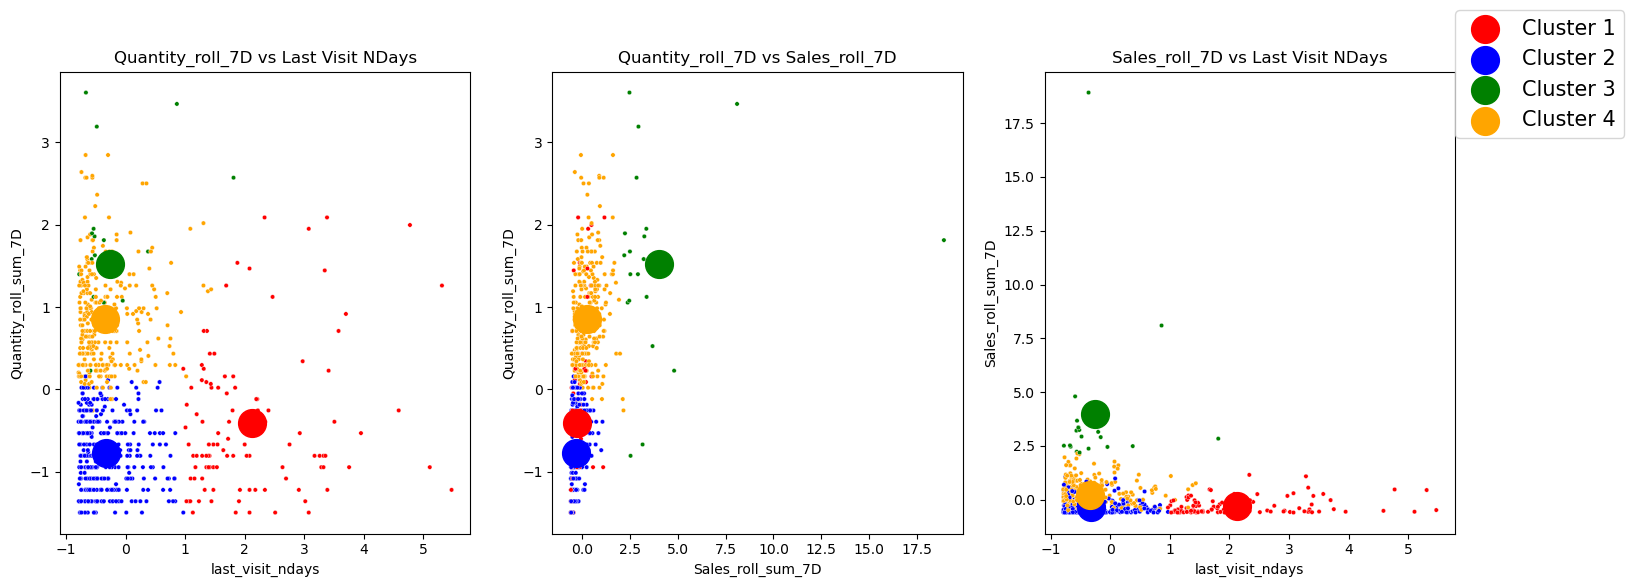

In [17]:
# Add labels to the txn_roll dataframe
Labels_df = pd.DataFrame(Labels, columns=['labels'])
data_to_plot = pd.concat([txn_roll, Labels_df], axis=1)

# Define custom colormap
custom_colors =['red', 'blue', 'green', 'orange']

# Plot scatterplots
fig, axs = plt.subplots(1,3, figsize=(18,6))

sns.scatterplot(data = data_to_plot, x = 'last_visit_ndays', y = 'Quantity_roll_sum_7D', hue='labels', palette = custom_colors, ax=axs[0], s=10, legend=False)
sns.scatterplot(data = data_to_plot, x = 'Sales_roll_sum_7D', y = 'Quantity_roll_sum_7D', hue='labels', palette = custom_colors, ax=axs[1], s=10, legend=False)
sns.scatterplot(data = data_to_plot, x = 'last_visit_ndays', y = 'Sales_roll_sum_7D', hue='labels', palette = custom_colors, ax=axs[2], s=10, legend=False)
axs[0].set_title('Quantity_roll_7D vs Last Visit NDays')
axs[1].set_title('Quantity_roll_7D vs Sales_roll_7D')
axs[2].set_title('Sales_roll_7D vs Last Visit NDays')

for clusternum in range(ClusterCentroids.shape[0]):
    axs[0].scatter(ClusterCentroids.loc[clusternum, 'last_visit_ndays'], ClusterCentroids.loc[clusternum, 'Quantity_roll_sum_7D'], marker='o',
                color = custom_colors[clusternum], label = f'Cluster {clusternum+1}', s=400)
    axs[1].scatter(ClusterCentroids.loc[clusternum, 'Sales_roll_sum_7D'], ClusterCentroids.loc[clusternum, 'Quantity_roll_sum_7D'], marker='o',
                color = custom_colors[clusternum], s=400)
    axs[2].scatter(ClusterCentroids.loc[clusternum, 'last_visit_ndays'], ClusterCentroids.loc[clusternum, 'Sales_roll_sum_7D'], marker='o',
                color = custom_colors[clusternum], s=400)

# Create legend for centroids only
fig.legend(loc='upper right', fontsize=15)
plt.show()

[Bonus] Question 4: Train k-means model using sklearn library and compare results to the model developed above.

In [18]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, init='random', random_state=42)
km.fit(txn_roll)
pd.DataFrame(km.cluster_centers_, columns = [txn_roll.columns])

,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
0,2.132168,-0.403174,-0.296161
1,-0.320506,-0.779312,-0.353523
2,-0.253915,1.528076,3.987407
3,-0.342518,0.857537,0.223230


In [19]:
ClusterCentroids

,last_visit_ndays,Quantity_roll_sum_7D,Sales_roll_sum_7D
labels,,,
0.0,2.121793,-0.412101,-0.298931
1.0,-0.324443,-0.777613,-0.352822
2.0,-0.253915,1.528076,3.987407
3.0,-0.342518,0.857537,0.223230


**Above we have the cluster centroids output by the sklearn KMeans function, and below them are printed the cluster centroids that were calculated using my code. We can see that the two algorithms found the same solutions.**

Question 5: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.